# Material Balances XVII

This Notebook begins consideration of semi-batch reactors; membrane reactors; recycle reactors, and packed beds with pressure drops.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

## Example Problem 01

The synthesis of Methyl Bromide is carried out in the liquid phase using a well-mixed tank reactor. 
			
$$C\!N\!Br + C\!H_3N\!H_2 \longrightarrow C\!H_3Br + N\!C\!N\!H_2$$

The tank is initially filled with 5L of a solvent solution containing Bromine Cyanide ($A$) at a concentration of 0.05M. At time $t = 0$, you turn on the feed to the reactor, which is a solvent solution containing methylamine ($B$) at a concentration of 0.025M; the feed enters the reactor at a total volumetric flowrate of $Q_f = 0.05 \ \mathrm{L \ s^{-1}}$. This reaction is first order in $A$ and first order in $B$, and we are given a rate constant of:

$$k = 2.2 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{s}^{-1}$$

All species are dissolved in an inert solvent and present at relatively low concentrations, so we can assume that the density of all fluid in the system is approximately equal to the density of the solvent. Plot the concentrations of all species in the reactor as well as the rate of reaction as a function of time.

How long does it take to reach 90% conversion of species $A$ in this system?

### Solution to Example Problem 01

We'll use the shorthand notation:

$$A + B \longrightarrow C + D$$

We write balances on each species:

```{tip}
This is the first time we've encountered a semi-batch reactor, but we have the framework for analysis in place already.  The general balance equation is sufficiently flexible to account for a well-mixed semi batch reactor:

$$\frac{dN_j}{dt} = F_{j,f} - F_{j} + R_{j}V$$

We simplify it as needed to account for the various inflows and outflows in a particular system, noting that it will simplify to a batch reactor balance for species that do not flow across the system boundary.  Convince yourself that this balance equation, written for species $A$, $B$, $C$, and $D$ in this system will result in the following four equations.
```

\begin{align*}
    \frac{dN_A}{dt} &= R_AV \\
    \frac{dN_B}{dt} &= F_{Bf} + R_BV \\
    \frac{dN_C}{dt} &= R_CV \\
    \frac{dN_D}{dt} &= R_DV
\end{align*}

The only new concept above is that, for species $B$, we have an inlet molar flowrate, so that (with respect to species $B$), this ends up looking like a non-steady state CSTR balance with no outflow. We can calculate the value of the feed molar flowrate of $B$ using information in the problem statement:

$$F_{Bf} = C_{Bf}Q_f$$

We define production rates, $R_j$, as functions of reaction rates, $r_i$:

\begin{align*}
    R_A &= -r \\
    R_B &= -r \\
    R_C &= r \\
    R_D &= r
\end{align*}

The single reaction rate, $r$, is given by the rate law specified in the problem statement (first order in each reactant):

$$r = kC_AC_B$$

Concentrations are defined using our state variables and volume:

\begin{align}
    C_A = \frac{N_A}{V} \\
    C_B = \frac{N_B}{V}
\end{align}

A small complication with this particular semi-batch reactor (compared to a constant volume batch reactor) is that the fluid Volume is clearly not constant since we have inflow with no outflow. We aren't given densities or molecular weights for these species, but we're told that the fluid phase density is constant and equal to that of the solvent. This makes it relatively easy to derive an equation that describes the change in volume with time. We starting with a total mass balance:

$$\frac{dm}{dt} = \dot{m}_{f}$$

We can express mass ($m$) and mass flowrate ($\dot{m}_{f}$) in terms of volume ($V$), volumetric flowrate ($Q_f$), and density ($\rho$):

$$\frac{d(\rho V)}{dt} = \rho Q_f$$

Since density is time invariant in this problem, this ODE simplifies to:

$$\frac{dV}{dt} = Q_f$$

This equation describes how fluid volume changes as a function of time. We have options as to how we couple this with the above ODEs given by component material balances. In this case, the differential equation for volume is independent of all other state variables. It is also a relatively straightforward ODE, so we have the option of solving it analytically. This results in an analytical solution for fluid volume as a function of time, which could be added to the ODE function as an explicit definition of reactor volume:

$$V = V_0 + Q_ft$$

That said, we do not have to solve analytically for $V(t)$ in order to solve this problem. We could also include $dV/dt$ in our system of ODEs and use `solve_ivp()` to integrate the volume differential equation alongside the four component material balances. This latter approach is actually more general, and it is the one we will need to use in more complex problems. Accordingly, we will solve this problem by including $V$ as a fifth state variable and solving $dV/dt$ numerically alongside the material balances.

In [20]:
##############################################################
# Defining some global constants for P01                     #
##############################################################

V0  = 5.0 #L
CA0 = 0.05 #mol/L
Qf  = 0.05 #L/s
CBf = 0.025 #mol/L
FBf = CBf*Qf
NA0 = CA0*V0
NB0 = 0.0
NC0 = 0.0
ND0 = 0.0
k   = 2.2  #L/mol/s

This reactor reaches 90% conversion at t = 282.390


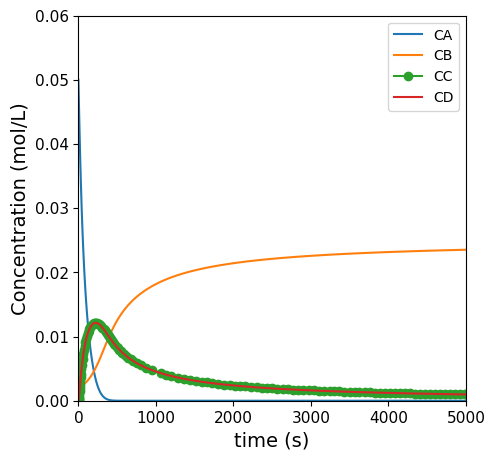

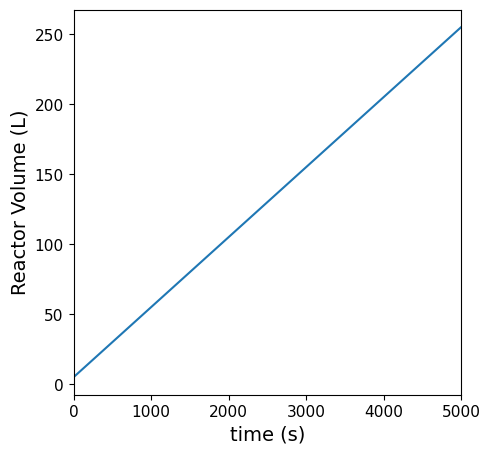

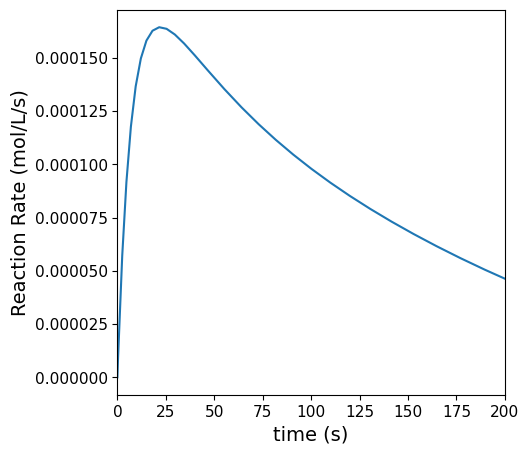

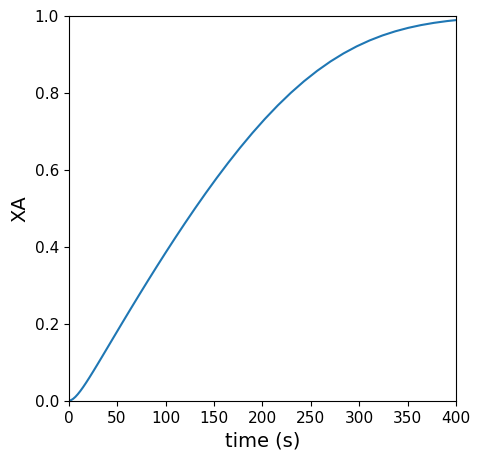

In [21]:
################################################################################
# Defining the ODE system in a function f(t, [NA, NB, NC, ND, V])              #
# This function returns [dNAdt, dNBdt, dNCdt, dNDdt, dVdt]                     #
################################################################################

def P01(t, var):
    
    NA, NB, NC, ND, V = var
        
    CA = NA/V
    CB = NB/V
    
    r  = k*CA*CB
    
    RA = -r
    RB = -r
    RC =  r
    RD =  r
    
    D1 =       RA*V
    D2 = FBf + RB*V
    D3 =       RC*V
    D4 =       RD*V
    D5 = Qf
    
    return [D1, D2, D3, D4, D5]

######################################################################################
# Defining integration span and initial state                                        #
######################################################################################

tspan = (0.0, 5000.0)
var0  = (NA0, NB0, NC0, ND0, V0)

######################################################################################
# Integrate the ODE system using solve_ivp()                                         #
######################################################################################

ans1  = solve_ivp(P01, tspan, var0, atol = 1e-8, rtol = 1e-8)

######################################################################################
# Extract necessary information from the solution structure                          #
######################################################################################

t     = ans1.t
NA    = ans1.y[0, :]
NB    = ans1.y[1, :]
NC    = ans1.y[2, :]
ND    = ans1.y[3, :]
V     = ans1.y[4, :]

######################################################################################
# Workup ODE output to calculate requested quantities                                #
######################################################################################

XA    = (NA0 - NA)/NA0
CA    = NA/V
CB    = NB/V
CC    = NC/V
CD    = ND/V
r     = k*CA*CB

######################################################################################
# Construct an interpolating polynomial approximation for t(XA); find t(0.9)         #
######################################################################################

itp1 = interp1d(XA, t)
print(f'This reactor reaches 90% conversion at t = {itp1(0.9):0.3f}')

######################################################################################
# Graph species concentration vs. time                                               #
######################################################################################

plt.figure(figsize = (5, 5))
plt.plot(t, CA, label = 'CA')
plt.plot(t, CB, label = 'CB')
plt.plot(t, CC, marker = 'o', label = 'CC')
plt.plot(t, CD, label = 'CD')
plt.xlim(0.0, max(tspan))
plt.xticks(fontsize = 11)
plt.xlabel('time (s)', fontsize = 14)
plt.ylim(0.0, 0.06)
plt.yticks(fontsize = 11)
plt.ylabel('Concentration (mol/L)', fontsize = 14)
plt.legend()
plt.show()

#######################################################################################
# Graph fluid volume vs. time                                                         #
#######################################################################################

plt.figure(figsize = (5, 5))
plt.plot(t, V)
plt.xlim(0.0, max(tspan))
plt.xticks(fontsize = 11)
plt.xlabel('time (s)', fontsize = 14)
plt.yticks(fontsize = 11)
plt.ylabel('Reactor Volume (L)', fontsize = 14)
plt.show()

#######################################################################################
# Graph reaction rate vs. time                                                        #
#######################################################################################

plt.figure(figsize = (5, 5))
plt.plot(t, r)
plt.xlim(0.0, 200)
plt.xticks(fontsize = 11)
plt.xlabel('time (s)', fontsize = 14)
plt.yticks(fontsize = 11)
plt.ylabel('Reaction Rate (mol/L/s)', fontsize = 14)
plt.show()

#######################################################################################
# Graph XA vs. time                                                                   #
#######################################################################################

plt.figure(figsize = (5, 5))
plt.plot(t, XA, label = 'XA')
plt.xlim(0.0, 400)
plt.xticks(fontsize = 11)
plt.xlabel('time (s)', fontsize = 14)
plt.ylim(0.0, 1.0)
plt.yticks(fontsize = 11)
plt.ylabel('XA', fontsize = 14)
plt.show()


(example-problem-01)=
## Example Problem 02

You are designing a flow reactor in order to perform gas-phase propane dehydrogenation.  The purpose of this reaction is "on purpose" generation of propylene, which has historically been produced as a side product of ethylene synthesis via naphtha cracking. One of the consequences of the shale gas boom is that it greatly expanded the supply of ethane (and thus decrease the cost of ethane).  Accordingly, the majority of our ethylene production has shifted to ethane pyrolysis, which does not produce significant quantities of propylene.  Hence your interest in an on-purpose synthesis of propylene!
			
$$C_3H_8 \longleftrightarrow C_3H_6 + H_2$$

The reaction has an elementary rate law, and it is performed at $T = 500\mathrm{K}$ and $P = 8.2 \ \mathrm{atm}$. At this temperature, the forward rate constant and the concentration-based equilibrium constant, $K_C$, are:

\begin{align*}
    k_f &= 0.7  \ \textrm{min}^{-1} \\
    K_C &= 0.05 \ \textrm{mol} \ \textrm{L}^{-1}				
\end{align*}			

If the feed rate of propane to the reactor is $F_{Af} = 10 \ \mathrm{moles \ min^{-1}}$, find the PFR volume required to achieve 95\% conversion of propane.

### Solution to Example Problem 02

Our instinct for solving this problem (how large does the reactor need to be to accomplish a specified conversion of propane?) is to write a balance on each species:

$$\frac{dF_j}{dV} = R_j$$

We can then specify a production rate for each species in terms of the reaction rate:

$$R_j = \sum_i \nu_{i,j}r_i$$

This leads to the three following species production rates:

\begin{align*}
    R_A &= -r \\
    R_B &= r \\
    R_C &= r
\end{align*}

The reaction is reversible, and we are told that the rate law follows elementary kinetics; therefore:

$$r = k_fC_A - k_rC_BC_C$$

For a flow reactor, we can define concentrations in terms of molar and volumetric flowrates:

$$C_j = \frac{F_j}{Q}$$

For a gas-phase system at low pressure, it is sufficient to define $Q$ using the ideal gas law. This is not the most accurate approximation at $P = 8.2 bar$, but we will use it because we don't have another fully parameterized equation of state on hand.

$$Q = \frac{F_T RT}{P}$$

In terms of parameters, we are given $k_f$, $T$, $P$, and $F_{Af}$. We can infer that $F_{Bf}$ and $F_{Cf}$ are both zero. Finally, we can calculate the reverse rate constant:

$$k_r = \frac{k_f}{K_C}$$

With this, we can solve the problem by integrating the coupled system of ODEs using `solve_ivp()`. This will produce an array of species flowrates at discrete values of PFR volume. We can then use those results to calculate fractional conversion of propane at various reactor volumes. We can then fit an interpolating polynomial to the set of $X_A$ and $V$ data using `interp1d()`, and use this to determine the volume where we hit our target conversion. This is all included in the code cell below.

```{caution}
The code cell below will result in an error when executed. This is intentionally left in the example to prompt a discussion of why we observe the error. It is resolved in the subsequent sections.
```

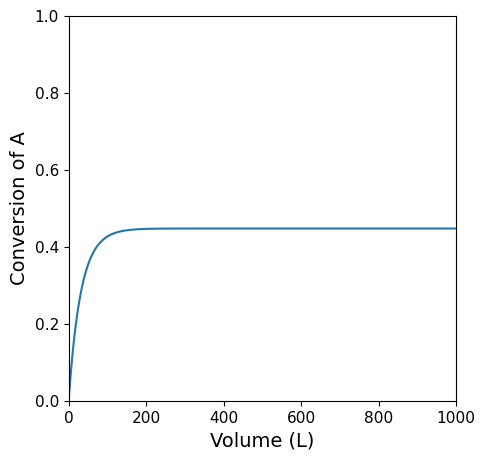

ValueError: A value (0.95) in x_new is above the interpolation range's maximum value (0.4473444481820728).

In [22]:
###################################################################
# Global constants for P02                                        #
###################################################################

kf  = 0.7  #1/min
KC  = 0.05 #mol/L
kr  = kf/KC #L/mol/min
T   = 500 #K
P   = 8.2 #atm
R   = 0.08206 #L*atm/mol/K
FAf = 10.0 #mol/min
FBf = 0.0
FCf = 0.0
FTf = FAf + FBf + FCf
XA_target = 0.95

###################################################################
# Define the ODE system as f(V, [FA, FB, FC])                     #
# function will return [dFAdV, dFBdV, dFCdV]                      #
###################################################################

def P02(V, var):
    FA, FB, FC = var
    
    FT = FA + FB + FC
    
    Q  = FT*R*T/P
    
    CA = FA/Q
    CB = FB/Q
    CC = FC/Q
    
    r  = kf*CA - kr*CB*CC
    
    RA = -r
    RB =  r
    RC =  r
    
    dA = RA
    dB = RB
    dC = RC
    
    return [dA, dB, dC]

####################################################################
# Define the integration span and initial state of each variable   #
####################################################################

Vspan = (0.0, 1000.0)
var0  = (FAf, FBf, FCf)

####################################################################
# Integrate the ODE system using solve_ivp()                       #
####################################################################

ans2  = solve_ivp(P02, Vspan, var0, atol = 1e-8, rtol =  1e-8)

####################################################################
# Extract important data from the solution structure               #
####################################################################

V     = ans2.t
FA    = ans2.y[0]
FB    = ans2.y[1]
FC    = ans2.y[2]

####################################################################
# Calculate fractional conversions                                 #
####################################################################

XA    = (FAf - FA)/FAf

#################################################################################################
# Graph XA vs. Volume -- why does XA stop increasing even though the reactor is getting larger? #
#################################################################################################

plt.figure(figsize = (5, 5))
plt.plot(V, XA)
plt.xlim(0.0, max(Vspan))
plt.xticks(fontsize = 11)
plt.xlabel('Volume (L)', fontsize = 14)
plt.ylim(0.0, 1.0)
plt.yticks(fontsize = 11)
plt.ylabel('Conversion of A', fontsize = 14)
plt.show()

####################################################################
# Construct interpolating polynomial approximation for V(XA)       #
# Attempt to find V(0.95)                                          #
####################################################################

itp1 = interp1d(XA, V)
itp1(XA_target) #This will throw an error since the maximum conversion reached is less than XA = 0.95

#### Always assess the equilibrium limit!

We failed to consider the equilibrium limit before we asked for 95% conversion. If we solve the equilibrium problem, we can see how attainable conversion depends on the specifications for this problem. The best way to solve this is using methods similar to those originally presented during the analysis of ammonia synthesis in [Notebook 07](https://jqbond.github.io/CEN587/Notebooks/587-N07.html). The basic approach is to start by recognizing that we need to solve an algebraic equation given by the definition of a concentration-based equilibrium constant:

$$K_C - \prod_j C_j^{\nu_j} = 0$$

To do so, we develop a mole table that relates all species flowrates to either fractional conversion or extent of reaction. Because we are mostly discussing fractional conversion in this problem, it is convenient to use this approach. The mole table below defines all species flowrates as functions of fractional conversion of propane.

|Species |In       |Change        |End                  |
|:-------|:-------:|:------------:|:-------------------:|
| $A$    |$F_{Af}$ |$- F_{Af}X_A$ |$F_{Af} - F_{Af}X_A$ | 
| $B$    |$F_{Bf}$ |$+ F_{Af}X_A$ |$F_{Bf} + F_{Af}X_A$ |
| $C$    |$F_{Cf}$ |$+ F_{Af}X_A$ |$F_{Cf} + F_{Af}X_A$ |
| Total  |$F_{Tf}$ |$+ F_{Af}X_A$ |$F_{Tf} + F_{Af}X_A$ |

Doing so, we can create a univariate function that can be solved using `opt.newton()` or analogous methods.  In this function, we need only make sure that all terms on the right hand side of the objective $0 = K_C - \prod_j C_j^{\nu_j}$ are defined as constants or as functions of $X_A$. We do so by defining species concentrations as functions of molar and volumetric flowrates:

$$C_j= \frac{F_j}{Q}$$

We define the volumetric flowrate using the ideal gas law, which is a little bit of a stretch at 8.2 bar, but we'll do it since we don't have a better equation of state on hand.

$$Q = \frac{F_T RT}{P}$$

Ultimately, we find that, under the conditions specified, the maximum possible conversion that can be achieved in this reactor is $X_A \approx 0.45$, which is consistent with the largest value of $X_A$ we observed by integrating the ODE system in [Example Problem 02](#example-problem-02) to $V \rightarrow \infty$

In [24]:
################################################################################
# Define a univariate function of XA that can be solved with opt.newton()      #
################################################################################

def eqns2a(XA):
      
    FA = FAf - FAf*XA
    FB = FBf + FAf*XA
    FC = FCf + FAf*XA
    FT = FTf + FAf*XA #equivalent to FT = FA + FB + FC
    
    Q  = FT*R*T/P
    
    CA = FA/Q
    CB = FB/Q
    CC = FC/Q
        
    KC_comp = CC*CB/CA
    
    eqn1    = KC_comp - KC
    return eqn1

################################################################################
# Provide an initial guess of what the root is                                 #
################################################################################

XAguess = 0.7

################################################################################
# Find the root using opt.newton(); print the answer                           #
################################################################################

ans3    = opt.newton(eqns2a, XAguess)
print(f'The equilibrium conversion of propane at these conditions is {ans3:0.3f}')

The equilibrium conversion of propane at these conditions is 0.447


## Example 03: Increasing the attainable equilibrium conversion

From the above analysis of equilibrium limits for these conditions, we learn that it is impossible to attain the requested conversion under the given conditions. Since this is a reaction where the number of moles increase with reaction (assuming we do not change the temperature), the only way we can improve the equilibrium limit so that we can reach the requested 95% conversion is to either 

1. Reduce the system pressure (increasing pressure favors the side of the reaction with fewer moles).
2. Add an inert gas diluent (this accomplishes the same thing as reducing the pressure in an equilibrium analysis). 
3. Do some combination of the above two things if it is more practical. 

With that in mind, we should determine what extent of changes are necessary in order to allow us to achieve $X_A \geq 0.95$ at equilibrium. We will modify the equilibrium solution above by adding a diluent species to the system and/or reducing the operating pressure as much as necessary. We don't know exactly the extent of changes necessary, so this will require some iterations. To make the solution as general as possible, let's modify the above function so that it accepts extra parameters $(P, F_{If})$. We can then pass these to `opt.newton()` using the `args` keyword. In doing so, we make it straightforwad to solve the equilibrium problem for any pressure and any amount of diluent gas added to the feed.

The only change to the above equations is that, when we have a diluent gas in the system, we need to account for its impact on concentration. We do so by ensuring that we modify the definition of total molar flowrate so that it also includes the inert gas. This is relatively straightforward because the inert gas is not participating in the reaction, so its quantity is unchanged as reaction occurs:

|Species |In       |Change        |End                  |
|:-------|:--------|:-------------|:--------------------|
| $A$    |$F_{Af}$ |$- F_{Af}X_A$ |$F_{Af} - F_{Af}X_A$ | 
| $B$    |$F_{Bf}$ |$+ F_{Af}X_A$ |$F_{Bf} + F_{Af}X_A$ |
| $C$    |$F_{Cf}$ |$+ F_{Af}X_A$ |$F_{Cf} + F_{Af}X_A$ |
| $I$    |$F_{If}$ |$0          $ |$F_{If}            $ | 
| Total  |$F_{Tf}$ |$+ F_{Af}X_A$ |$F_{Tf} + F_{Af}X_A$ |

As we change $P$ and $F_{If}$, we'll find that we need to essentially dilute the system by a factor of 1000 in order to achieve an equilibrium converion above 95%. This can be accomplished by running at lower pressures (minimum of 1 bar, most likely) and adding ~ 100 mol/min of inert gas.

In [32]:
#########################################################################
# Define a univariate function with extra args f(XA, P, FIf)            #
# Still solving 0 = KC - CB*CC/CA                                       #
#########################################################################

def eqns3(XA, P, FIf):
        
    FA = FAf - FAf*XA
    FB = FBf + FAf*XA
    FC = FCf + FAf*XA
    FI = FIf
    FT = FA + FB + FC + FI
    
    Q  = FT*R*T/P
    
    CA = FA/Q
    CB = FB/Q
    CC = FC/Q
        
    KC_comp = CC*CB/CA
    
    eqn1    = KC_comp - KC
    return eqn1


##########################################################################
# Solve problem with trial guesses for P and FIf                         #
##########################################################################
XAguess = 0.95
Pt      = 1.0 #bar
FIft    = 100   #mol/min
ans3    = opt.newton(eqns3, XAguess, args = (Pt, FIft))
print(f'The equilibrium conversion of propane at these conditions is \n {ans3:0.3f}')

The equilibrium conversion of propane at these conditions is 
 0.962


In [ ]:
# ##########################################################
# # Redefining globals at adjusted pressure and w/diluent  #
# ##########################################################

# KC  = 0.05 #mol/L
# T   = 500 #K
# P   = 8.2 #atm
# R   = 0.08206 #L*atm/mol/K
# FAf = 10.0 #mol/min
# FBf = 0.0
# FCf = 0.0
# FIf = 0.0 #mol/min

# # Solve problem with current set of globals
# XAguess = 0.95
# ans3    = opt.newton(eqns2b, XAguess)
# print(f'The equilibrium conversion of propane at these conditions is \n {ans3:0.3f}')

#### Returning to the material balances under conditions where we can reach 95% conversion

Next, we re-solve the material balances with conditions where it will be possible to reach 95% conversion to solve for the required reactor volume.  Specifically, we reduce the system pressure to 1 atm, and we add a diluent (e.g., $N_2$ gas) to the feed stream at 100 moles per minute.

In [ ]:
# def P02b(V, var):
#     FA, FB, FC = var
#     FI = FIf
    
#     FT = FA + FB + FC + FI
    
#     Q  = FT*R*T/P
    
#     CA = FA/Q
#     CB = FB/Q
#     CC = FC/Q
    
#     r  = kf*CA - kr*CB*CC
    
#     RA = -r
#     RB =  r
#     RC =  r
    
#     dA = RA
#     dB = RB
#     dC = RC
    
#     return [dA, dB, dC]

In [ ]:
# Vspan = (0.0, 30000.0)
# var0  = (FAf, FBf, FCf)
# ans2  = solve_ivp(P02b, Vspan, var0, atol = 1e-8, rtol =  1e-8)

# V     = ans2.t
# FA    = ans2.y[0, :]
# FB    = ans2.y[1, :]
# FC    = ans2.y[2, :]

# XA    = (FAf - FA)/FAf

# plt.figure(1, figsize = (5, 5))
# plt.plot(V, XA)
# plt.xlim(0.0, max(Vspan))
# plt.xticks(fontsize = 11)
# plt.xlabel('Volume (L)', fontsize = 14)
# plt.ylim(0.0, 1.0)
# plt.yticks(fontsize = 11)
# plt.ylabel('Conversion of A', fontsize = 14)
# plt.show(1)

# itp1 = interp1d(XA, V, kind = 'cubic')
# Vopt = itp1(XA_target)
# print(f'The Volume required for XA = {XA_target:0.2f} is {Vopt:0.0f}L')